# Sounds from patterns

Generate tones from a symmetric pattern. Proof of concept! 

Tech 411.05 *Patterns and Symmetry*, University of New Hampshire, J. Gibson, 2024.



## Generate a pattern

The code in the next few cells is taken from the random pattern generator.


In [1]:
using LinearAlgebra, Plots

"""
return 2 x 2 rotation matrix that rotates plane by angle θ
"""
rotation(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]

"""
Generate symmetries of the n-gon that rotate and flip the n-gon in the plane.
The return value is an array of matrices representing the elements of the group.
"""
function dihedralgroup(n, withflip=true)
    S = [-1 0; 0 1]                 # a reflection about y axis
    I = [1.0 0.0; 0.0 1.0]          # the identity
    Dn = fill(I, withflip ? 2n : n) # allocate an array of 2n or n matrices
    
    for k=1:n
        Dn[k] = rotation(2(k-1)π/n) # set Dn[k] to rotation by θ = 2(k-1)π/n
        if withflip
            Dn[k+n] = S*Dn[k]       # set Dn[k+n] to reflection of Dn[k]
        end
    end
    Dn
end

"""
Symmetrize a set of data points X by symmetry group G. The return value
is a matrix containing all columns of X mapped by all matrices in G
"""
function symmetrize(X, G)
    m,nX = size(X)  # nX is number of data points
    nG = length(G)  # nG is number elements in group
    
    GX = fill(0.0, 2, nX*nG) # allocate a matrix for G applied to X
    
    for j in 1:nX      # for each datapoint in X...
        for k in 1:nG  # ...and for each matrix in the group...
            GX[:, (j-1)*nG + k] = G[k]*X[:,j] # ...map the jth datapoint by the kth matrix
        end
    end
    GX
end

"""
return sum_j cos(k|x-xj|) exp(-a|x-xj|^2) where x is a vector and xj is the jth column of matrix X
"""
function f(x, X, a=1, k=1)
    s = 0.0
    for j in 1:size(X, 2)
        r = norm(x-X[:,j])
        s += cos(k*r)*exp(-a*(r^2))
    end
    s
end


plotpattern

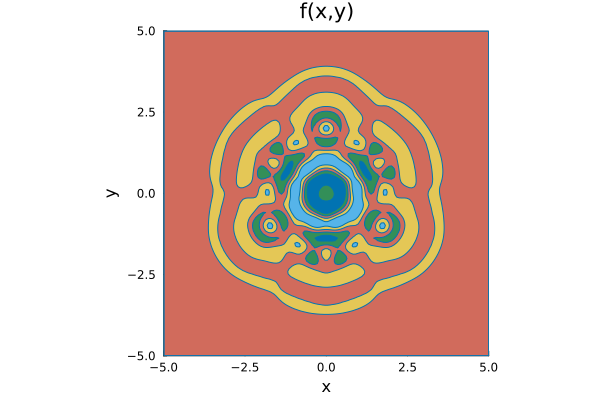

In [70]:
# pattern parameters
n = 3     # n-gon dihedral group
N = 7     # number of random points
a = 1     # scale of blobs (larger a, narrower blobs)
k = 7     # scale of ripples (larger k, more rapid ripples)
s = 1     # scale of data points (larger s, further spread out)
flip = true

w = 5       # width of plot: -l < x < l, -r < y < r, 
levels = 4  # number of colorlevels
colormap =  :seaborn_colorblind6  #:Paired_8 (search on "Julia Plots colormaps" to find other color palettes)

X = randn(2, N)
X[:,1] = [0; 2]

# symmetrize the data points X with the symmetries of the n-gon
G = dihedralgroup(n, flip)
Xsymm = symmetrize(s*X, G)

# generate a function f(x) = sum_j cos(k|x-xj|) exp(-a|x-xj|^2) where a,k,xj are fixed
f(x) = f(x, Xsymm, a, k)

# evaluate f(x) over a grid of points x=[x1;x2]
x1grid = range(-w, w, length=128)
x2grid = range(-w, w, length=128)
fgrid = [f([x1;x2], Xsymm, a, k) for x2 in x2grid, x1 in x1grid]

# make a contour plot of zgrid = f(x, Xsymm, a, k)
fscale = maximum(abs.(fgrid))
contourf(x1grid, x2grid, fgrid/fscale, color=colormap, levels=levels, legend=:none)
plot!(xlim=(-w,w), ylim=(-w,w), aspect_ratio=1)
p1 = plot!(xlabel="x", ylabel="y", title="f(x,y)")


## Extract a 1d signal from the 2d pattern

The pattern is a contour plot of a 2d function $f(x,y)$ (or $f(x)$ where $x = [x_1, x_2]$).

We need to extract a 1d signal from the 2d function. Do this by drawing a line
on the $x,y$ plane and then evaluating $f(x,y)$ along the line. 

One way to define a line is to set its angle $\theta$ and $y$ offset $b$. Then 
the $(x,y)$ points on the line are given by 
\begin{align*}
   x &= s \cos \theta \\
   y &= s \sin \theta + b
\end{align*}
where $s$ is a varying real number. 

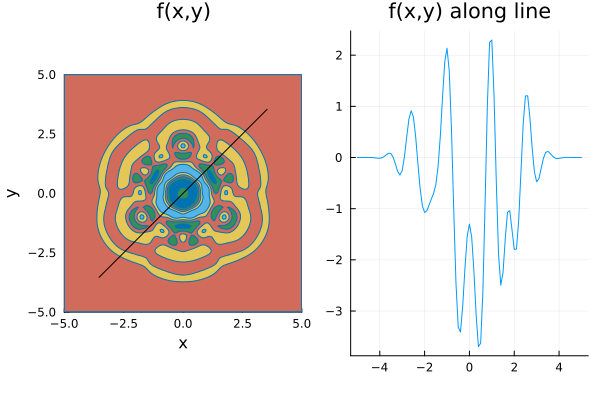

In [75]:
# define line by angle and vertical offset
θ = pi/4
b = 0 #1

# compute x,y values along line
s = -5:0.1:5
y = s*sin(θ) .+ b
x = s*cos(θ)

# superimpose line on plot of pattern
plot(p1)
p2 = plot!(x,y, linecolor = :black)

# evaluate f(x,y) along line
fline = [f([x[i], y[i]]) for i in 1:length(s)]
plot(s, fline, label="")
p3 = plot!(title="f(x,y) along line")

plot(p2,p3)

## Compute power spectrum of 1d signal


In [40]:
using FFTW

function powerspectrum(u, x)
    Nx = length(x)
    Lx = (x[end] - x[1])*(Nx/(Nx-1))
    α = 2pi/Lx
 
    # perform Fourier transform on ugrid = vector of gridpoint values if u(x)
    # to get uhat = vector of complex amplitudes of frequencies
    uhat = (1/Nx)*fft(u) 

    # just consider positive frequencies (negatives have same magnitude since signal is real)
    Nfreq = Nx÷2
    k = 0:Nfreq-1

    # compute power[k] = |uhat[k]|^2
    # and     freq[k]  = α k 
    power = abs.(2*uhat[1:Nfreq]).^2  # factor of two to include equal negative frequencies
    power[1] = abs(uhat[1])^2          # remove factor of 2 for frequency-zero mode, which has no negative counterpart
    freq = α*k

    return power, freq
end

powerspectrum (generic function with 1 method)

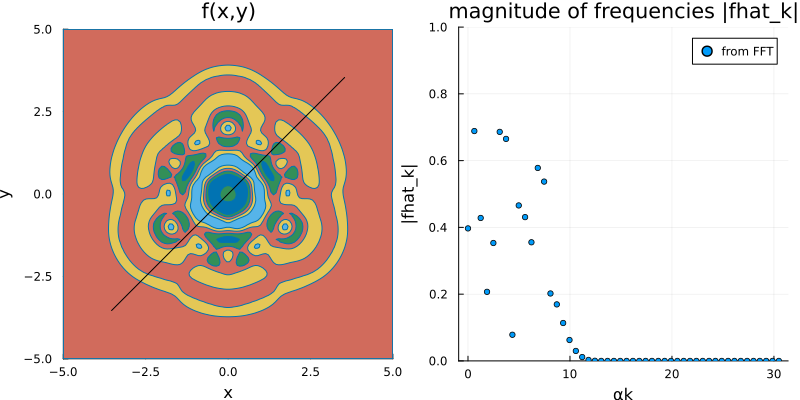

In [76]:
fpower, freq = powerspectrum(fline,r)
fmagn = sqrt.(fpower)

scatter(freq, fmagn, markersize=3, label="from FFT", ylim=(0,1))
p4 = plot!(xlabel="αk", title="magnitude of frequencies " * "|fhat_k|", ylabel="|fhat_k|")

plot(p2,p4, size=(800,400))


### Build a sound from the power spectrum

In [84]:
using Sound

N = 4    # play the N largest-magnitude frequencies in signal
S = 8192 # sampling rate in Hz

# sort and reorder spectrum by magnitude
I = sortperm(fmagn, rev=true)
fmagn = fmagn[I]
ffreq = freq[I]

# rebuild a signal from the top N frequencies and their magnitudes
S2 = S÷2
t = 2π*(1:S2)/S
snd = zeros(S2)

# this adds up the various component frequencies with same magnitude (volume)
# as in the original signal. Multiply frequencies by 1000 to get them in 
# audible range

for i in 1:N
    snd += fmagn[3]*cos.(1000*ffreq[i]*t)
end

sound(0.5*snd, S) # monophonic


4096

##### 